In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn
import glob

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_88710/3311630280.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Sha

In [3]:
results = []

for results_file in glob.glob('/Users/gocchini/Desktop/CC_project/tutorial_following/*.pkl'):
    df = pd.read_pickle(results_file)
    results.append(df)

all_results = pd.concat(results, axis=0, ignore_index=True)


In [7]:
list_of_postcodes = all_results['website_postcodes'].to_list()
postcodes = [item for item in list_of_postcodes if str(item) != 'nan']

In [24]:
all_postcodes = [keys for dictionary in postcodes for keys, values in dictionary.items()]
all_postcodes_df = pd.DataFrame(all_postcodes, columns = ['postcode'])

In [17]:
uk_postcodes_centroids = pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')[['pcd', 'lat', 'long']]

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_88710/3768931562.py:1: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_postcodes_centroids = pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')[['pcd', 'lat', 'long']]


In [27]:
match_postcodes_centroids = all_postcodes_df.merge(uk_postcodes_centroids, right_on = 'pcd', left_on= 'postcode', how = 'right')

In [33]:
true_postcodes = match_postcodes_centroids[match_postcodes_centroids['postcode'].notna()]

In [35]:
true_postcodes = true_postcodes[~(true_postcodes['lat'] > 60)]

In [37]:
bristol_postcodes = pd.read_csv('/Users/gocchini/Desktop/CC_project/bristol_postcodes.csv')['Postcode']

In [38]:
cc_bristol_postcodes = true_postcodes[true_postcodes['pcd'].isin(bristol_postcodes)]

In [40]:
bristol_shp = gpd.read_file('/Users/gocchini/Desktop/CC_project/bristol/bristol.shp')

<Axes: >

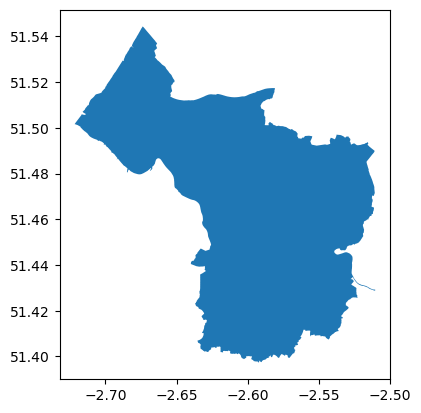

In [51]:
bristol_shp.plot()

In [41]:
bristol_coordinates = cc_bristol_postcodes[['lat', 'long']]

In [42]:
points = bristol_coordinates.apply(lambda r: Point(r.long, r.lat), axis=1)

In [45]:
gdb = gpd.GeoDataFrame(bristol_coordinates.assign(geometry=points), \
                       crs={'init' :'epsg:4326'})

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [46]:
xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

<Axes: >

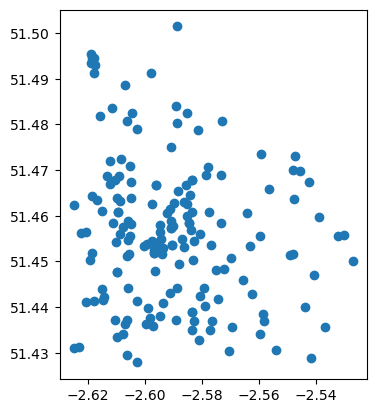

In [47]:
gdb.plot()

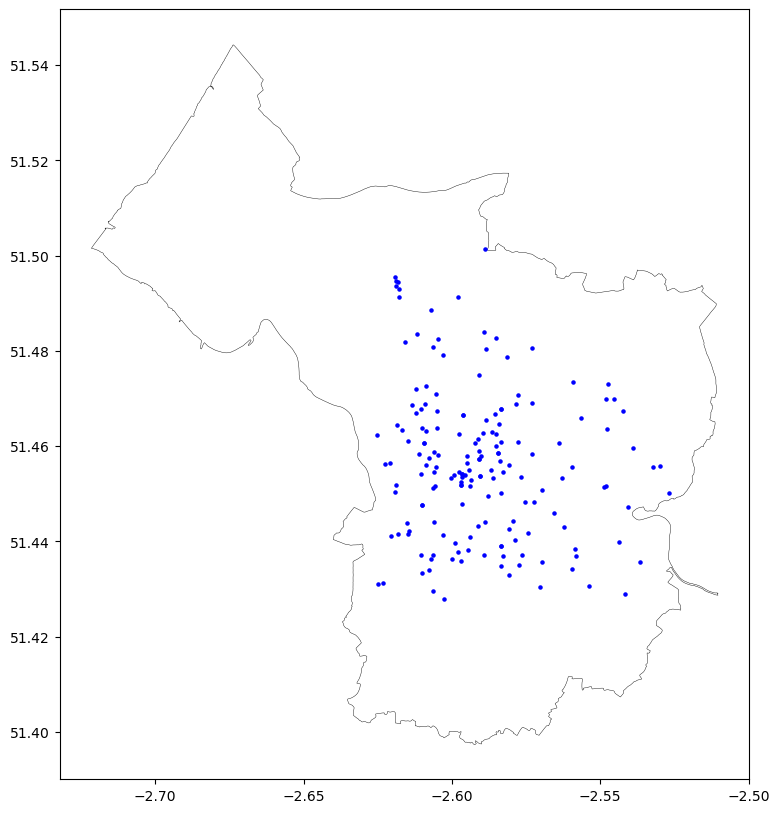

In [52]:
f, ax = plt.subplots(1, figsize=(10, 10))
# Add a base layer with the LSOA geography
bristol_shp.plot(ax = ax, color='white', edgecolor='black', linewidth=0.3)
#generate KDE
gdb.plot(ax=ax, color = 'blue', markersize = 5)
plt.show()